## Making sense of Vector Autoregressive (VAR) model

Let's consider a dynamic system of two variables $x_{t}$ and $y_{t}$ which is represented by the following equations

$x_{t} = 0.3 x_{t-1} + 0.2 x_{t-2} + 0.3 y_{t-1} + 0.2 y_{t-2} + \varepsilon_{xt} $

$y_{t} = 0.2 x_{t} + 0.4 x_{t-1} - 0.1 x_{t-2} + 0.4 y_{t-1} - 0.1 y_{t-2} + \varepsilon_{yt} $

where $\varepsilon_{xt}$ and $\varepsilon_{yt}$ follow $N(0,\sigma ^{2})$ process. Only $x_{t}$ has contemporaneous effect on $y_{t}$.

Now, import the necessary packages for analysis and initialize the coefficients.

In [1]:
import numpy.random as random
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR

#true coefficients
b11 = 0.3
b12 = 0.2
b13 = 0.3
b14 = 0.2

b21 = 0.2
b22 = 0.4
b23 = -0.1
b24 = 0.4
b25 = -0.1

---
Now generating impulse responses for the true coefficient given one unit of shock for $x_{t}$ and $y_{t}$

---

Text(0.5, 1.0, 'shock y -> impulse responses')

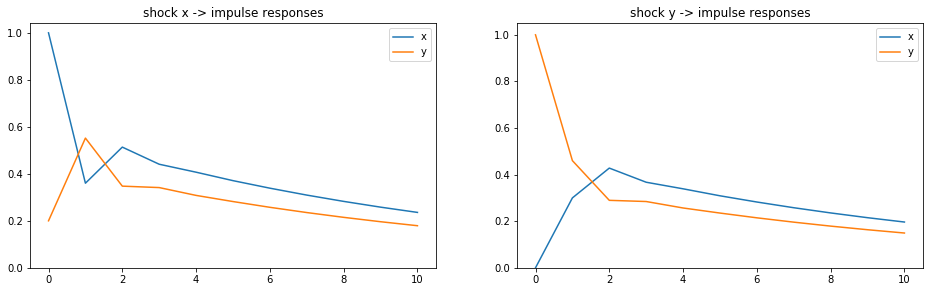

In [2]:
#Impulse response generation function given shock, coefficients and period
def gen_IRF(shocks, coefs, irf_period):
  x_irf = [0,0] # initializing and setting values for x(t-2) and x(t-1)
  y_irf = [0,0] # initializing and setting values y(t-2) and y(t-1)

  for i in range(irf_period+1):
    t = i+2
    if t == 2:
      x_shock = shocks['x']
      y_shock = shocks['y']
    else:
      x_shock = 0
      y_shock = 0

    x_irf.append(coefs[0][0]*x_irf[t-1] 
                 + coefs[0][1]*x_irf[t-2] 
                 + coefs[0][2]*y_irf[t-1] 
                 + coefs[0][3]*y_irf[t-2] 
                 + x_shock)
    
    y_irf.append(coefs[1][0]*x_irf[t] 
                 + coefs[1][1]*x_irf[t-1] 
                 + coefs[1][2]*x_irf[t-2] 
                 + coefs[1][3]*y_irf[t-1] 
                 + coefs[1][4]*y_irf[t-2] 
                 + y_shock)

  x_irf = [round(e,5) for e in x_irf]
  x_irf = x_irf[2:]
  y_irf = [round(e,5) for e in y_irf]
  y_irf = y_irf[2:]

  return pd.DataFrame({'x':x_irf, 'y':y_irf})

#coefficients
coefs = [
          [b11,b12,b13,b14],
          [b21,b22,b23,b24,b25]
        ]

#shock on x
shocks = {'x':1, 'y':0} #shock in x for time t
df_irf_x_shock = gen_IRF(shocks, coefs, 10)

#shock on y
shocks = {'x':0, 'y':1} #shock in y for time t
df_irf_y_shock = gen_IRF(shocks, coefs, 10)

#plotting impulse responses of given
fig = plt.figure(figsize=(16,4.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(df_irf_x_shock[['x','y']])
ax1.legend(['x','y'])
ax1.set_ylim(0)
ax1.set_title("shock x -> impulse responses")

ax2.plot(df_irf_y_shock[['x','y']])
ax2.legend(['x','y'])
ax2.set_ylim(0)
ax2.set_title("shock y -> impulse responses")

---
Generating sample size of 1000 and using OLS to estimate coefficients.

---

In [3]:
#initializing x and y variable
x = [0,0]
y = [0,0]

random.seed(0)
sample_size = 1000

for t in range(2,sample_size):
    x.append( b11*x[t-1] + b12*x[t-2] + b13*y[t-1] + b14*y[t-2] + random.randn())
    y.append( b21*x[t] + b22*x[t-1] + b23*x[t-2] + b24*y[t-1] + b25*y[t-2] + random.randn())

#creating dataframe
df = pd.DataFrame({'x':x, 'y':y})

In [4]:
def lag(variable, lag): #function for lag
    if lag == 0:
        return variable
    if isinstance(variable, pd.Series):
        return variable.shift(-lag) 
    else:
        variable = pd.Series(x)
        return variable.shift(-lag)

#running OLS without intercept
reg_1 = smf.ols(formula='x ~ lag(x,-1) + lag(x,-2) + lag(y,-1) + lag(y,-2) - 1 ', data=df).fit()
reg_2 = smf.ols(formula='y ~ lag(x,0) + lag(x,-1) + lag(x,-2) + lag(y,-1) + lag(y,-2) - 1 ', data=df).fit()
print(reg_1.summary(),'\n \n')
print(reg_2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      x   R-squared (uncentered):                   0.742
Model:                            OLS   Adj. R-squared (uncentered):              0.741
Method:                 Least Squares   F-statistic:                              715.1
Date:                Sat, 22 Aug 2020   Prob (F-statistic):                   1.10e-290
Time:                        16:47:02   Log-Likelihood:                         -1387.6
No. Observations:                 998   AIC:                                      2783.
Df Residuals:                     994   BIC:                                      2803.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

---
Generating impluse responses from the coefficients obtained from OLS.

---

In [5]:
#coefficient estimates from OLS
coefs = [
          [reg_1.params[0],reg_1.params[1],reg_1.params[2],reg_1.params[3]],
          [reg_2.params[0],reg_2.params[1],reg_2.params[2],reg_2.params[3],reg_2.params[4]]
        ]

#generating impluse responses from the coefficient estimates from OLS
df_irf_x_shock_simulated = gen_IRF({'x':1,'y':0},coefs,10)
df_irf_y_shock_simulated = gen_IRF({'x':0,'y':1},coefs,10)

df_irf_x_shock_simulated.rename(columns={'x':'x_simulated','y':'y_simulated'}, inplace=True)
df_irf_y_shock_simulated.rename(columns={'x':'x_simulated','y':'y_simulated'}, inplace=True)

df_irf_x_shock = df_irf_x_shock.join(df_irf_x_shock_simulated)
df_irf_y_shock = df_irf_y_shock.join(df_irf_y_shock_simulated)

Text(0.5, 1.0, 'shock y -> response of y')

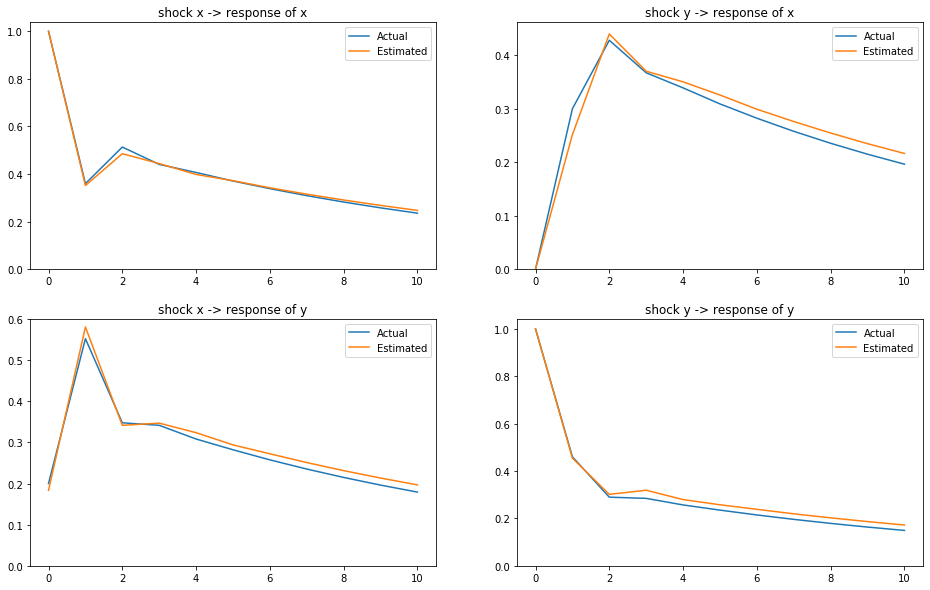

In [6]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(df_irf_x_shock[['x','x_simulated']])
ax1.legend(['Actual','Estimated'])
ax1.set_ylim(0)
ax1.set_title("shock x -> response of x")

ax2.plot(df_irf_y_shock[['x','x_simulated']])
ax2.legend(['Actual','Estimated'])
ax2.set_ylim(0)
ax2.set_title("shock y -> response of x")

ax3.plot(df_irf_x_shock[['y','y_simulated']])
ax3.legend(['Actual','Estimated'])
ax3.set_ylim(0)
ax3.set_title("shock x -> response of y")

ax4.plot(df_irf_y_shock[['y','y_simulated']])
ax4.legend(['Actual','Estimated'])
ax4.set_ylim(0)
ax4.set_title("shock y -> response of y")

---
## VAR estimation using VAR package of statsmodels
https://www.statsmodels.org/dev/vector_ar.html#vector-ar--page-root

Initiating VAR instance and optimum lag order selection. Here, we select lag of 2 i.e. VAR(P) is VAR(2).

In [7]:
model = VAR(df[['x','y']])
print(model.select_order(15).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.595       1.605       4.927       1.599
1      0.03906     0.06886       1.040     0.05039
2    -0.09283*   -0.04316*     0.9113*   -0.07394*
3     -0.08851    -0.01897      0.9153    -0.06206
4     -0.08222    0.007187      0.9211    -0.04821
5     -0.07734     0.03194      0.9256    -0.03578
6     -0.07348     0.05567      0.9292    -0.02436
7     -0.07511     0.07391      0.9277    -0.01843
8     -0.07112     0.09777      0.9314   -0.006881
9     -0.06515      0.1236      0.9369    0.006638
10    -0.05917      0.1495      0.9426     0.02018
11    -0.05514      0.1733      0.9464     0.03176
12    -0.04903      0.1993      0.9522     0.04543
13    -0.04230      0.2259      0.9586     0.05972
14    -0.04038      0.2477      0.9605     0.06920
15    -0.04002      0.2679      0.9608     0.07712
-------------------------------

In [8]:
result = model.fit(2) #fitting the model with VAR of 2 lags.
print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Aug, 2020
Time:                     16:47:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0299900
Nobs:                     998.000    HQIC:                -0.0604614
Log likelihood:          -2782.71    FPE:                   0.923905
AIC:                   -0.0791459    Det(Omega_mle):        0.914717
--------------------------------------------------------------------
Results for equation x
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.023860         0.031014           -0.769           0.442
L1.x          0.305076         0.030300           10.069           0.000
L1.y          0.251443         0.031107            8.083           0.000
L2.x          0.185806 

---
#### VAR stability check. 
Stability requires that the roots lie outside the unit circle i.e. the inverse of roots should be within the unit root circle. Here, we used inverse of the roots to check stability and all the roots are inside the unit root circle.

---

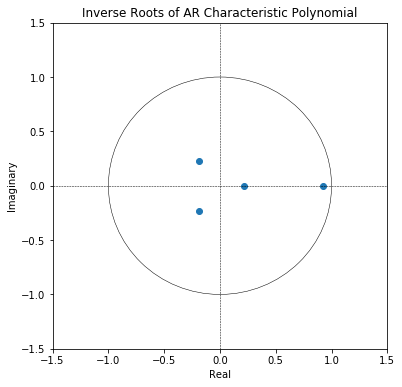

In [9]:
inv_of_roots = 1/result.roots #inverse of the roots

plt.figure(figsize=(6,6))
plt.scatter(inv_of_roots.real, inv_of_roots.imag) #scatter plot of complex number
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, linewidth=0.5)) #circle plotting
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Inverse Roots of AR Characteristic Polynomial')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)

---
### Impulse responses of the shock
Orthogonalization is done using the Cholesky decomposition of the estimated error covariance matrix $Σ_{u}$ and hence interpretations may change depending on variable ordering. Order of $x_{t}$ , $y_{t}$ means $x_{t}$ has contemporenous effect on $y_{t}$ and not the reverse is true.

---

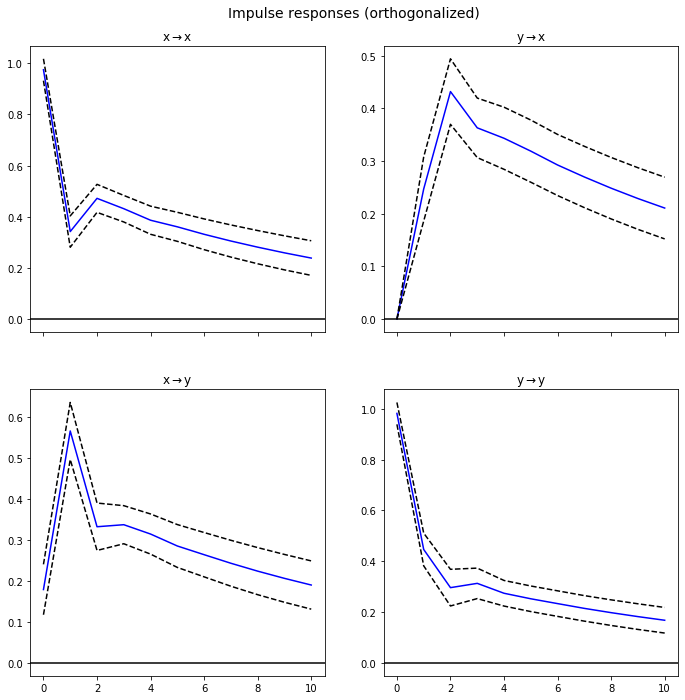

In [10]:
irf = result.irf(10)
plot1 = irf.plot(orth=True)

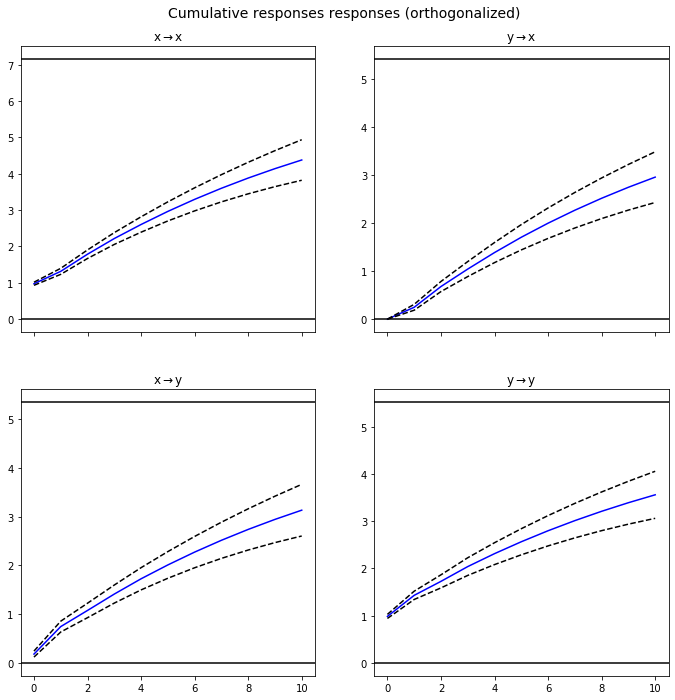

In [11]:
plot2 = irf.plot_cum_effects(orth=True) #cummulative impulse responses

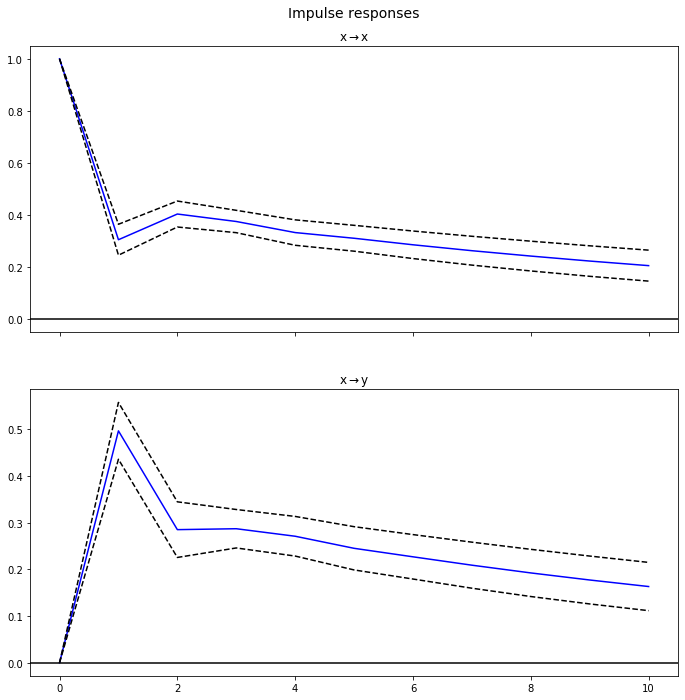

In [12]:
plot3 = irf.plot(impulse='x') #impulse responses of selected variable

In [13]:
extracted_irfs = irf.orth_irfs
extracted_stderr = irf.stderr(orth=True)

df_irf = pd.DataFrame({
                        'x_x': [ extracted_irfs[i][0][0] for i in range(len(extracted_irfs)) ],
                        'y_x': [ extracted_irfs[i][0][1] for i in range(len(extracted_irfs)) ],
                        'x_y': [ extracted_irfs[i][1][0] for i in range(len(extracted_irfs)) ],
                        'y_y': [ extracted_irfs[i][1][1] for i in range(len(extracted_irfs)) ],
                        'x_x_stderr': [ extracted_stderr[i][0][0] for i in range(len(extracted_stderr)) ],
                        'y_x_stderr': [ extracted_stderr[i][0][1] for i in range(len(extracted_stderr)) ],
                        'x_y_stderr': [ extracted_stderr[i][1][0] for i in range(len(extracted_stderr)) ],
                        'y_y_stderr': [ extracted_stderr[i][1][1] for i in range(len(extracted_stderr)) ],
                      })
df_irf['x_x_upper'] = df_irf['x_x'] + 1.96 * df_irf['x_x_stderr']
df_irf['x_x_lower'] = df_irf['x_x'] - 1.96 * df_irf['x_x_stderr']

df_irf['y_x_upper'] = df_irf['y_x'] + 1.96 * df_irf['y_x_stderr']
df_irf['y_x_lower'] = df_irf['y_x'] - 1.96 * df_irf['y_x_stderr']

df_irf['x_y_upper'] = df_irf['x_y'] + 1.96 * df_irf['x_y_stderr']
df_irf['x_y_lower'] = df_irf['x_y'] - 1.96 * df_irf['x_y_stderr']

df_irf['y_y_upper'] = df_irf['y_y'] + 1.96 * df_irf['y_y_stderr']
df_irf['y_y_lower'] = df_irf['y_y'] - 1.96 * df_irf['y_y_stderr']

df_irf

,x_x,y_x,x_y,y_y,x_x_stderr,y_x_stderr,x_y_stderr,y_y_stderr,x_x_upper,x_x_lower,y_x_upper,y_x_lower,x_y_upper,x_y_lower,y_y_upper,y_y_lower
0,0.973952,0.000000,0.178516,0.981987,0.021800,0.000000,0.031340,0.021980,1.016681,0.931224,0.000000,0.000000,0.239943,0.117090,1.025067,0.938906
1,0.342017,0.246914,0.565000,0.446196,0.031236,0.031043,0.035473,0.032858,0.403239,0.280794,0.307758,0.186070,0.634528,0.495472,0.510599,0.381794
2,0.471757,0.431668,0.331577,0.295876,0.027907,0.031702,0.029475,0.036828,0.526454,0.417060,0.493804,0.369533,0.389348,0.273806,0.368059,0.223694
3,0.431317,0.362902,0.336547,0.312741,0.026442,0.028804,0.023676,0.030604,0.483144,0.379490,0.419358,0.306447,0.382952,0.290142,0.372726,0.252757
4,0.386301,0.343119,0.313787,0.273746,0.028020,0.030055,0.024958,0.025713,0.441220,0.331382,0.402027,0.284211,0.362705,0.264870,0.324144,0.223348
5,0.360567,0.318694,0.284655,0.252024,0.028923,0.030084,0.026646,0.025694,0.417256,0.303878,0.377658,0.259730,0.336881,0.232430,0.302384,0.201664
6,0.331368,0.292410,0.263463,0.233015,0.030636,0.029571,0.027560,0.025698,0.391415,0.271321,0.350368,0.234452,0.317480,0.209447,0.283382,0.182647
7,0.305107,0.269672,0.242574,0.214221,0.032030,0.029675,0.028553,0.025632,0.367887,0.242327,0.327836,0.211509,0.298539,0.186609,0.264459,0.163983
8,0.281149,0.248400,0.223362,0.197378,0.033112,0.029743,0.029276,0.025729,0.346049,0.216249,0.306697,0.190103,0.280743,0.165980,0.247807,0.146949
9,0.258936,0.228778,0.205776,0.181816,0.033946,0.029825,0.029741,0.025757,0.325470,0.192401,0.287236,0.170321,0.264068,0.147484,0.232300,0.131331


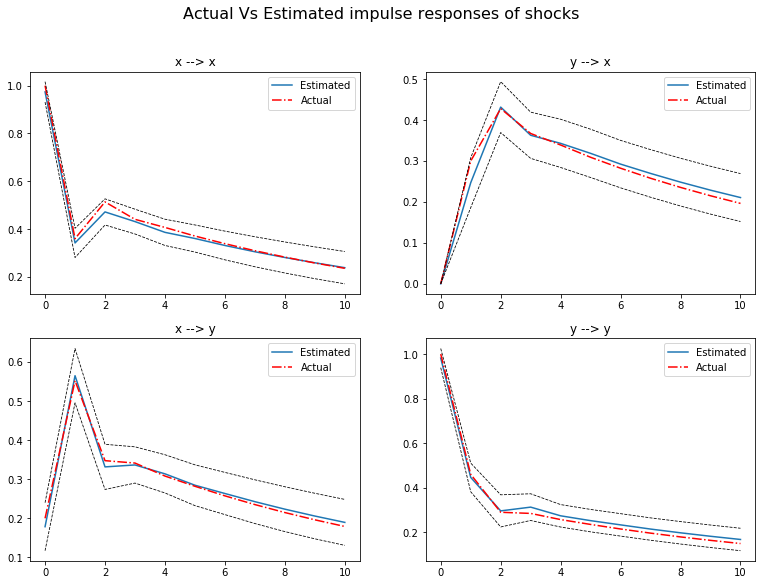

In [14]:
fig = plt.figure(figsize=(13, 9))
fig.suptitle("Actual Vs Estimated impulse responses of shocks", fontsize=16)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(df_irf['x_x'])
ax1.plot(df_irf_x_shock['x'], linestyle='-.', color='red')
ax1.plot(df_irf[['x_x_upper','x_x_lower']],color='black',linewidth=0.8,linestyle='--')
ax1.set_title('x --> x')
ax1.legend(['Estimated','Actual'])

ax2.plot(df_irf['y_x'])
ax2.plot(df_irf_y_shock['x'], linestyle='-.', color='red')
ax2.plot(df_irf[['y_x_upper','y_x_lower']],color='black',linewidth=0.8,linestyle='--')
ax2.set_title('y --> x')
ax2.legend(['Estimated','Actual'])

ax3.plot(df_irf['x_y'])
ax3.plot(df_irf_x_shock['y'], linestyle='-.', color='red')
ax3.plot(df_irf[['x_y_upper','x_y_lower']],color='black',linewidth=0.8,linestyle='--')
ax3.set_title('x --> y')
ax3.legend(['Estimated','Actual'])

ax4.plot(df_irf['y_y'])
ax4.plot(df_irf_y_shock['y'], linestyle='-.', color='red')
ax4.plot(df_irf[['y_y_upper','y_y_lower']],color='black',linewidth=0.8,linestyle='--')
ax4.set_title('y --> y')
ax4.legend(['Estimated','Actual'])